<a href="https://colab.research.google.com/github/jepowo/ComputerVision_-CrashCourse-/blob/main/CPE313_ACT4_Edge_and_ContourDetection_cpe32s8_DelaRosaJohnErrol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 018
Code Title: | Emerging Technologies in CpE 1 - Fundamentals of Computer Vision
1st Semester | AY 2023-2024
<hr> | <hr>
<u>**ACTIVITY NO. 4** | **Edge and Contour Detection**
**Name** | LastName, FirstName
**Section** | CPE31Sx
**Date Performed**: |
**Date Submitted**: |
**Instructor**: | Dr. Jonathan V. Taylar / Engr. Verlyn V. Nojor / Engr. Roman M. Richard

<hr>

## 1. Objectives

This activity aims tointroduce students to the use of OpenCV for edge detection and contour detection.

## 2. Intended Learning Outcomes (ILOs)
After this activity, the students should be able to:
* Explain fundamental idea of convolution and the kernel's importance.
* Use different image manipulation methods by using openCV functions.
* Perform contour and edge line drawing on their own images.

## 3. Procedures and Outputs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
grumpy_path = 'content/drive/My Drive/meimeis/Culture-Grumpy-Cat.png'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2

# This is the file URL: https://media.wired.com/photos/5cdefb92b86e041493d389df/4:3/w_1330,h_998,c_limit/Culture-Grumpy-Cat-487386121.jpg
# src = cv2.imread(grumpy_path)
src = cv2.imread('Culture-Grumpy-Cat.png')
dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

Edges play a major role in both human and computer vision. We, as humans, can easily recognize many object types and their pose just by seeing a backlit silhouette or a rough sketch. Indeed, when art emphasizes edges and poses, it often seems to convey the idea of an archetype, such as Rodin's The Thinker or Joe Shuster's Superman.

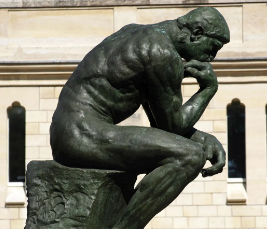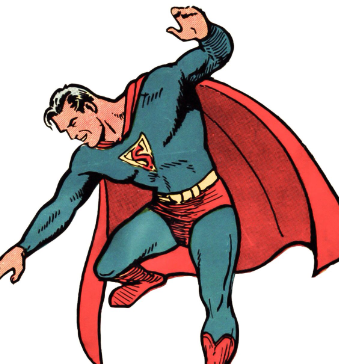

Software, too, can reason about edges, poses, and archetypes.

OpenCV provides many edge-finding filters, including Laplacian(), Sobel(), and Scharr(). These filters are supposed to turn non-edge regions to black while turning edge regions to white or saturated colors. However, they are prone to misidentifying noise as edges. This flaw can be mitigated by blurring an image before trying to find its edges. OpenCV also provides many blurring filters, including blur() (simple average), medianBlur(), and GaussianBlur(). The arguments for the edge-finding and blurring filters vary but always include ksize, an odd whole number that represents the width and height (in pixels) of a filter's kernel.

For blurring, let's use medianBlur(), which is effective in removing digital video noise, especially in color images. For edge-finding, let's use Laplacian(), which produces bold edge lines, especially in grayscale images. After applying medianBlur(), but before applying Laplacian(), we should convert the image from BGR to grayscale.

Once we have the result of Laplacian(), we can invert it to get black edges on a white background. Then, we can normalize it (so that its values range from 0 to 1) and multiply it with the source image to darken the edges. Let's implement this approach:

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(src)

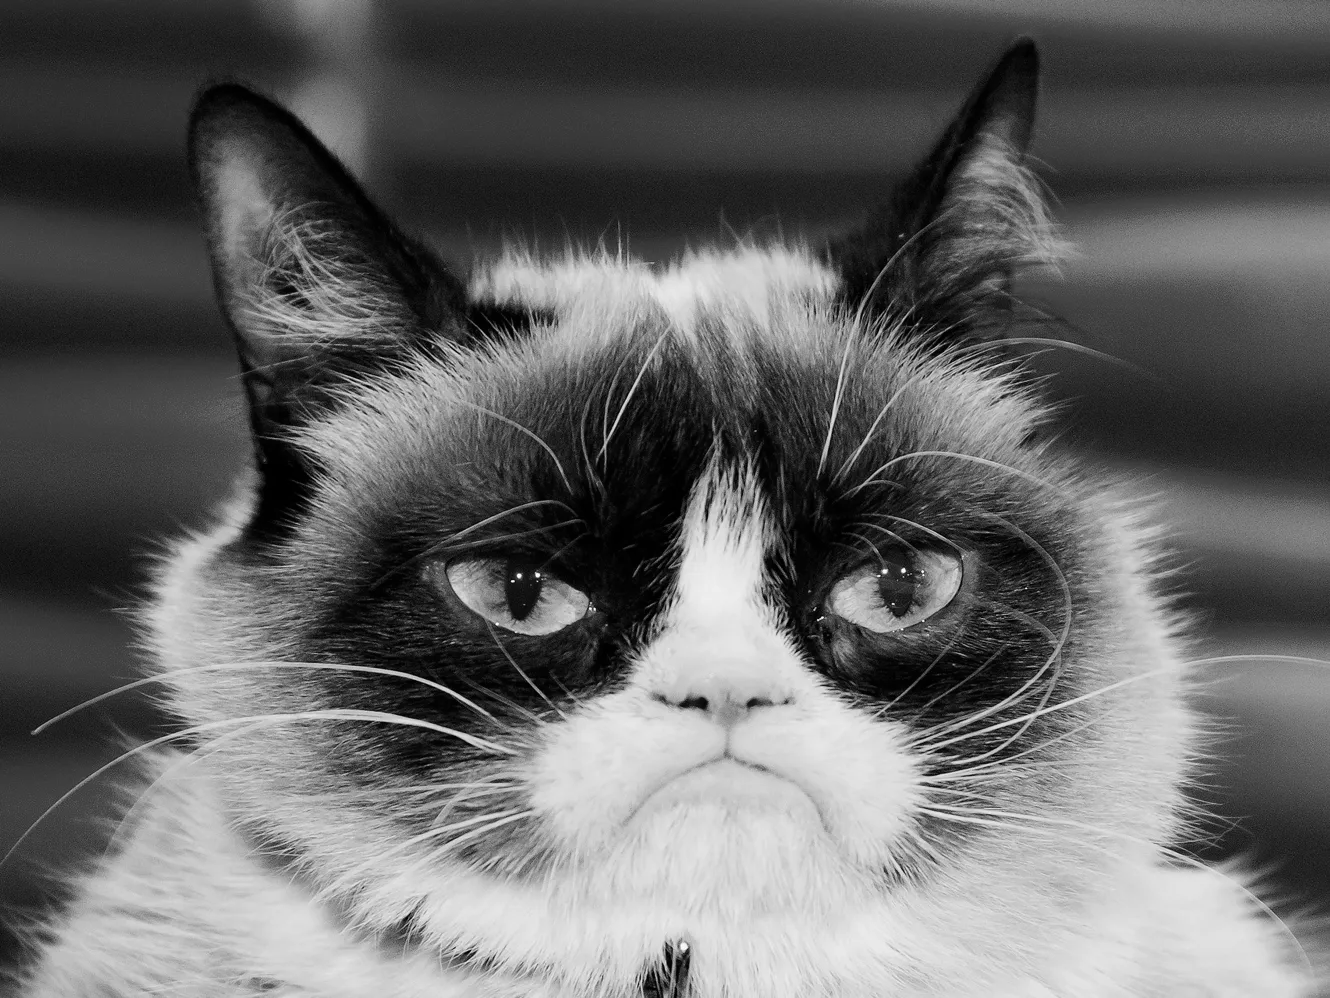

In [ ]:
cv2_imshow(dst)

In [ ]:
def strokeEdges(src, dst, blurKsize = 7, edgeKsize = 5):
  if blurKsize >= 3:
    blurredSrc = cv2.medianBlur(src, blurKsize)
    graySrc = cv2.cvtColor(blurredSrc, cv2.COLOR_BGR2GRAY)
  else:
    graySrc = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

  cv2.Laplacian(graySrc, cv2.CV_8U, graySrc, ksize = edgeKsize)
  normalizedInverseAlpha = (1.0 / 255) * (255 - graySrc)
  channels = cv2.split(src)

  for channel in channels:
    channel[:] = channel * normalizedInverseAlpha

  return cv2.merge(channels,dst)

**For the function above, provide an analysis:**
* Try to run the function and pass values for its parameters.
* Change the values in the kSize variables. What do you notice?

*Make sure to add codeblocks underneath this section to ensure that your demonstration of the procedure and answers are easily identifiable*

In [ ]:
# Sample

new_img = strokeEdges(src, dst)
cv2_imshow(new_img)

<hr/>

### Custom Kernels -- Getting Convoluted

As we have just seen, many of OpenCV's predefined filters use a kernel. Remember that a kernel is a set of weights, which determine how each output pixel is calculated from a neighborhood of input pixels. Another term for a kernel is a convolution
matrix. It mixes up or convolves the pixels in a region. Similarly, a kernel-based filter may be called a convolution filter.

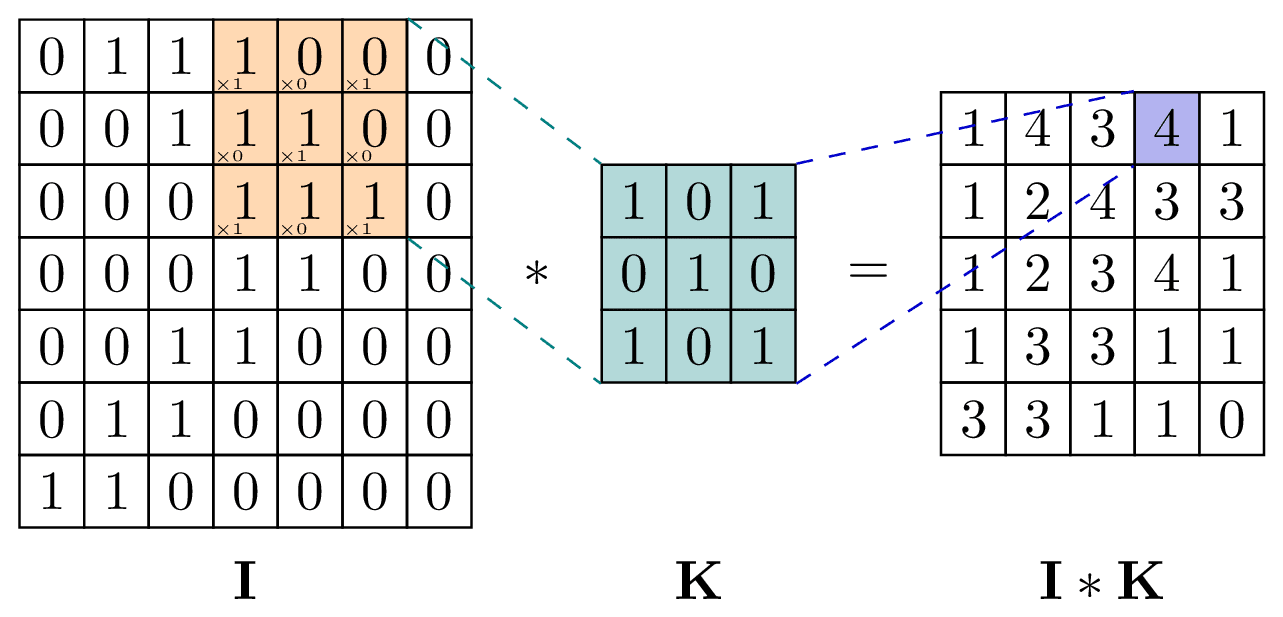

OpenCV provides a very versatile filter2D() function, which applies any kernel or convolution matrix that we specify. To understand how to use this function, let's first learn the format of a convolution matrix. It is a 2D array with an odd number of rows and columns. The central element corresponds to a pixel of interest and the other elements correspond to the neighbors of this pixel. Each element contains an integer or floating point value, which is a weight that gets applied to an input pixel's value.

In [ ]:
# Example

kernel = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])

In [ ]:
kernel

array([[-1, -1, -1],
       [-1,  9, -1],
       [-1, -1, -1]])

Here, the pixel of interest has a weight of 9 and its immediate neighbors each have a weight of -1. For the pixel of interest, the output color will be nine times
its input color minus the input colors of all eight adjacent pixels. If the pixel of interest is already a bit different from its neighbors, this difference becomes intensified. The effect is that the image looks sharper as the contrast between the neighbors is increased.

In [ ]:
# Applying the Kernel

# Reloading src and dst
src = cv2.imread('Culture-Grumpy-Cat.png')
dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Using the filter with our Kernel
new_img2 = cv2.filter2D(src, -1, kernel, dst)

# Display
cv2_imshow(new_img2)

**Answer the following with analysis**:
* What does filter2d() function do that resulted to this image above?
* Provide a comparison between this new image and the previous image that we were able to generate.

*Answer here*

<hr/>

Based on this simple example, let's add two classes. One class, VConvolutionFilter, will represent a convolution filter in general.
A subclass, SharpenFilter, will represent our sharpening filter specifically.

In [ ]:
class VConvolutionFilter(object):
  """a filter that applies a convolution to V (or all of BGR)."""

  def __init__(self, kernel):
    self._kernel = kernel

  def apply(self, src, dst):
    """ Apply the filter with a BGR or gray source/destination """
    cv2.filter2D(src, -1, self._kernel, dst)

In [ ]:
class SharpenFilter(VConvolutionFilter):
  """a sharpen filter with a 1-pixel radius."""

  def __init__(self):
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    VConvolutionFilter.__init__(self, kernel)

**Run the classes above, create objects and aim to show the output of the two classes. Afterwards, make sure to make an analysis of the output**.

In [ ]:
sharpen_filter = SharpenFilter()

sharpened_img = src.copy()
sharpen_filter.apply(src, sharpened_img)

In [ ]:
cv2_imshow(sharpened_img)

Note that the weights sum up to 1. This should be the case whenever we want to leave the image's overall brightness unchanged. If we modify a sharpening kernel
slightly so that its weights sum up to 0 instead, we have an edge detection kernel that turns edges white and non-edges black.

In [ ]:
class FindEdgesFilter(VConvolutionFilter):
  """An edge-finding filter with a 1-pixel radius."""

  def __init__(self):
    kernel = np.array([[-1, -1, -1],
                       [-1, 8, -1],
                       [-1, -1, -1]])
    VConvolutionFilter.__init__(self, kernel)

**Run this class and demonstrate the output. Provide an analysis**

In [ ]:
edges_filter = FindEdgesFilter()

edges_img = src.copy()
edges_filter.apply(src, edges_img)

In [ ]:
cv2_imshow(edges_img)

Next, let's make a blur filter. Generally, for a blur effect, the weights should sum up to 1 and should be positive throughout the neighborhood. For example, we can take a simple average of the neighborhood as follows

In [ ]:
class Blurfilter(VConvolutionFilter):
  """A blur filter with a 2-pixel radius"""

  def __init__(self):
    kernel = np.array([[0.04, 0.04, 0.04, 0.04, 0.04],
                       [0.04, 0.04, 0.04, 0.04, 0.04],
                       [0.04, 0.04, 0.04, 0.04, 0.04],
                       [0.04, 0.04, 0.04, 0.04, 0.04],
                       [0.04, 0.04, 0.04, 0.04, 0.04]])
    VConvolutionFilter.__init__(self, kernel)

**Run this class and demonstrate the output. Provide an analysis**

In [ ]:
blur_filter = Blurfilter()

blurred_img = src.copy()
blur_filter.apply(src, blurred_img)

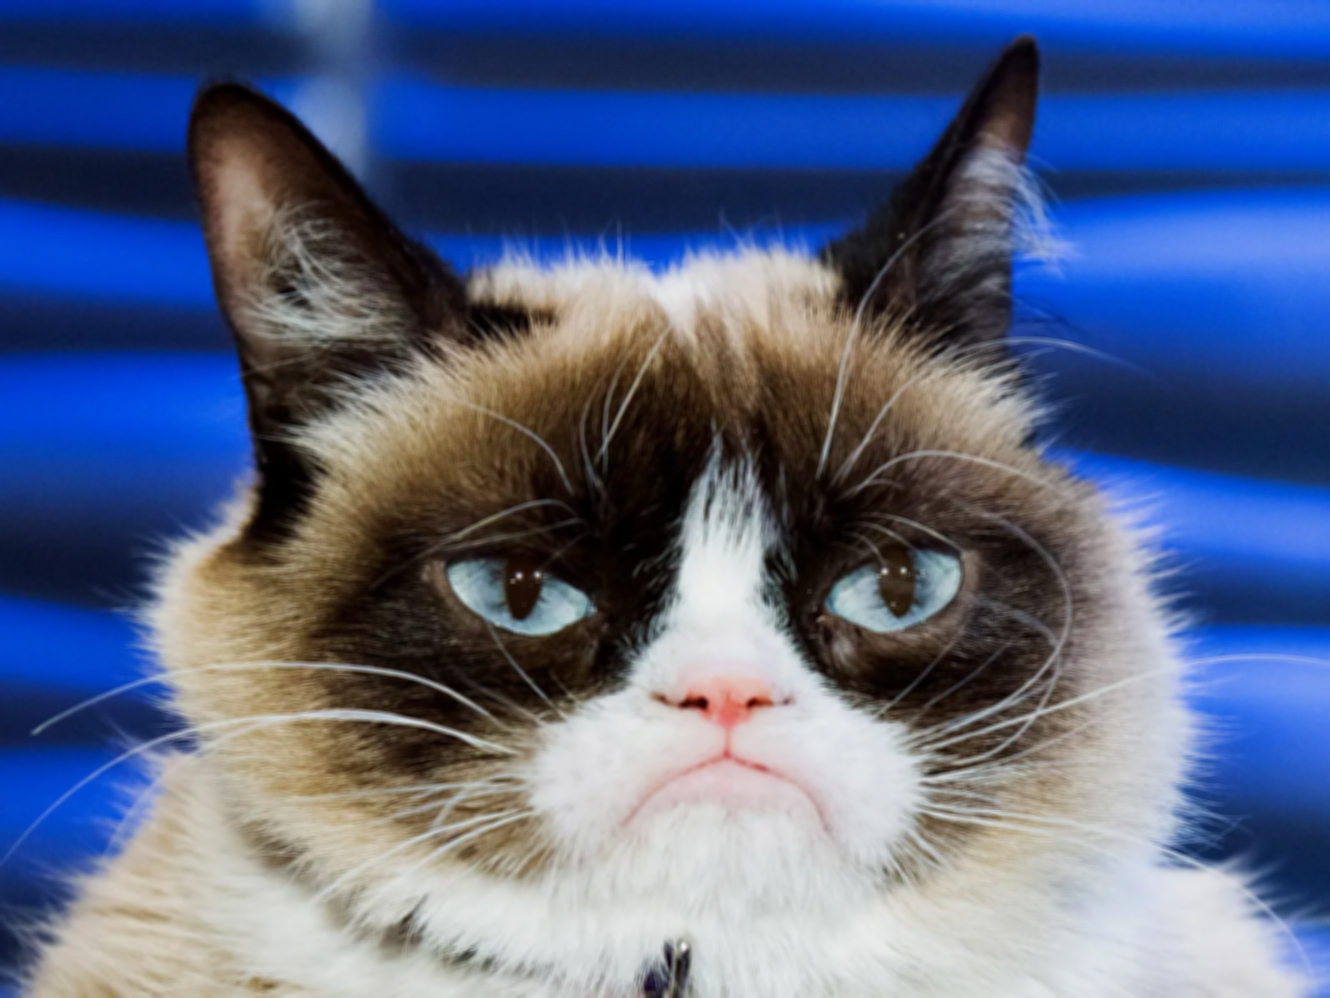

In [ ]:
cv2_imshow(blurred_img)

Our sharpening, edge detection, and blur filters use kernels that are highly symmetric. Sometimes, though, kernels with less symmetry produce an interesting
effect. Let's consider a kernel that blurs on one side (with positive weights) and sharpens on the other (with negative weights). It will produce a ridged or embossed effect.

In [ ]:
class EmbossFilter(VConvolutionFilter):
  """An emboss filter with a 1-pixel radius."""

  def __init__(self):
    kernel = np.array([[-2, -1, 0],
                       [-1, 1, 1],
                       [0, 1, 2]])
    VConvolutionFilter.__init__(self, kernel)

**Run this class and demonstrate the output. Provide an analysis**

In [ ]:
emboss_filter = EmbossFilter()

embossed_img = src.copy()
emboss_filter.apply(src, embossed_img)

In [ ]:
cv2_imshow(embossed_img)

### Edge Detection with Canny

OpenCV also offers a very handy function called Canny (after the algorithm's inventor, John F. Canny), which is very popular not only because of its  effectiveness, but also the simplicity of its implementation in an OpenCV program, as it is a one-liner:

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow

# img = cv2.imread('/content/Paimon.png', 0)
img = cv2.imread('Paimon-PNG.png', 0)
cv2.imwrite("canny.jpg", cv2.Canny(img, 200, 300))

True

array([[94, 94, 94, ..., 94, 94, 94],
       [94, 94, 94, ..., 94, 94, 94],
       [94, 94, 94, ..., 94, 94, 94],
       ...,
       [94, 94, 94, ..., 94, 94, 94],
       [94, 94, 94, ..., 94, 94, 94],
       [94, 94, 94, ..., 94, 94, 94]], dtype=uint8)
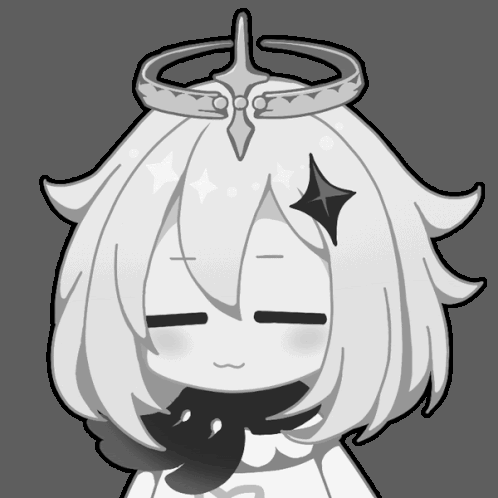

In [ ]:
img

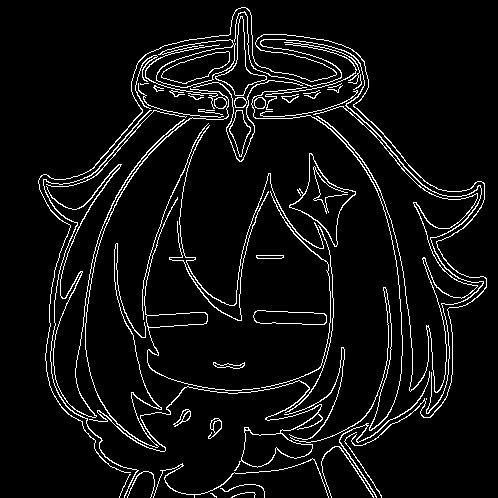

In [ ]:
img_canny = cv2.imread('/content/canny.jpg')
cv2_imshow(img_canny)

The Canny edge detection algorithm is quite complex but also interesting: it's a five-step process that denoises the image with a Gaussian filter, calculates gradients, applies non maximum suppression (NMS) on edges, a double threshold on all the
detected edges to eliminate false positives, and, lastly, analyzes all the edges and their connection to each other to keep the real edges and discard the weak ones.

**Try it on your own image, do you agree that it's an effective edge detection algorithm? Demonstrate your samples before making a conclusion**

In [ ]:
img = cv2.imread('Stewie-PNG.png', 0)
cv2.imwrite("canny.jpg", cv2.Canny(img, 200, 300))

True

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
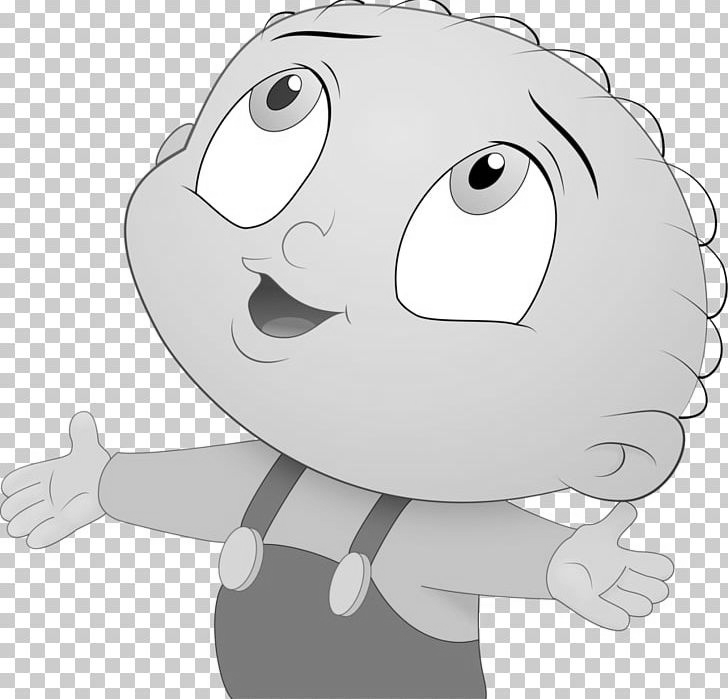

In [ ]:
img

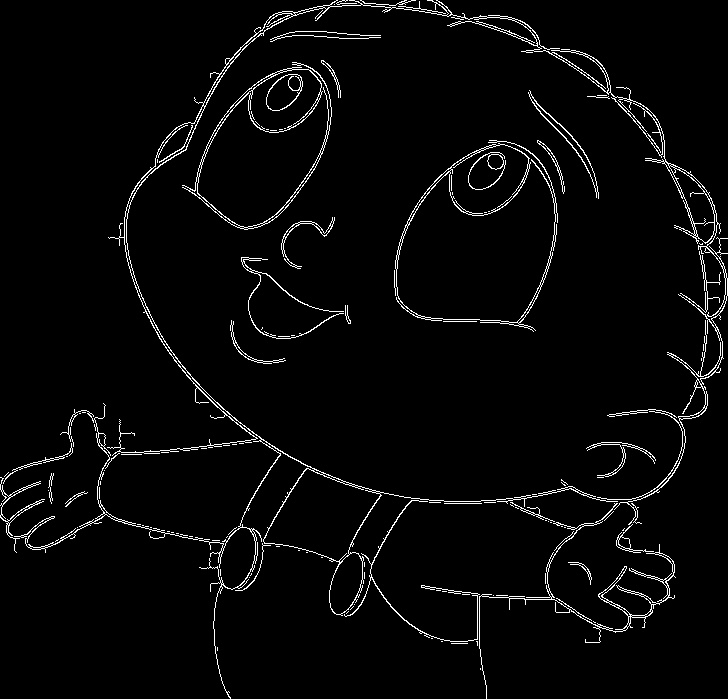

In [ ]:
img_canny = cv2.imread('/content/canny.jpg')
cv2_imshow(img_canny)

<hr/>

### Contour Detection

Another vital task in computer vision is contour detection, not only because of the obvious aspect of detecting contours of subjects contained in an image or video frame, but because of the derivative operations connected with identifying contours.

These operations are, namely, computing bounding polygons, approximating shapes, and generally calculating regions of interest, which considerably simplify interaction with image data because a rectangular region with NumPy is easily defined with an array slice. We will be using this technique a lot when exploring the concept of object detection (including faces) and object tracking.

In [ ]:
# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow

img = np.zeros((200,200), dtype=np.uint8)
img[50:150, 50:150] = 255

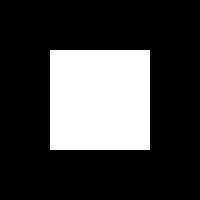

In [ ]:
cv2_imshow(img)

In [ ]:
ret, thresh = cv2.threshold(img, 127, 255, 0)
print(ret)
print(thresh)

127.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

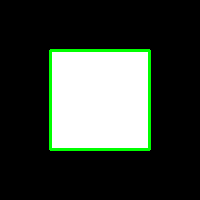

In [ ]:
img = cv2.drawContours(color, contours, -1, (0, 255, 0), 2)
cv2_imshow(color)

**What is indicated by the green box in the middle? Why are there no other green lines? Provided an analysis**

<hr/>

### Contours - bounding box, minimum area rectangle, and minimum enclosing circle

Finding the contours of a square is a simple task; irregular, skewed, and rotated shapes bring the best out of the cv2.findContours utility function of OpenCV. Consider this sample image:

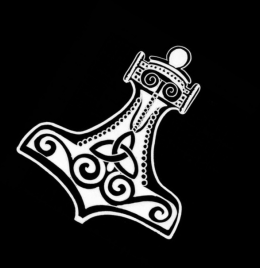

In a real-life application, we would be most interested in determining the bounding box of the subject, its minimum enclosing rectangle, and its circle. The cv2.findContours function in conjunction with a few other OpenCV utilities makes this very easy to accomplish:

In [ ]:
# import cv2
# import numpy as np

img = cv2.pyrDown(cv2.imread("Hammer-PNG.png", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)

array([[[199, 199, 199],
        [198, 198, 198],
        [209, 209, 209],
        ...,
        [254, 254, 254],
        [252, 252, 252],
        [227, 227, 227]],

       [[212, 212, 212],
        [212, 212, 212],
        [218, 218, 218],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [224, 224, 224]],

       [[246, 246, 246],
        [247, 247, 247],
        [237, 237, 237],
        ...,
        [203, 203, 203],
        [203, 203, 203],
        [221, 221, 221]],

       ...,

       [[203, 203, 203],
        [203, 203, 203],
        [212, 212, 212],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [227, 227, 227]],

       [[239, 239, 239],
        [238, 238, 238],
        [231, 231, 231],
        ...,
        [211, 211, 211],
        [212, 212, 212],
        [222, 222, 222]],

       [[255, 255, 255],
        [254, 254, 254],
        [241, 241, 241],
        ...,
        [199, 199, 199],
        [200, 200, 200],
        [222, 222, 222]]], dtype=uint8)
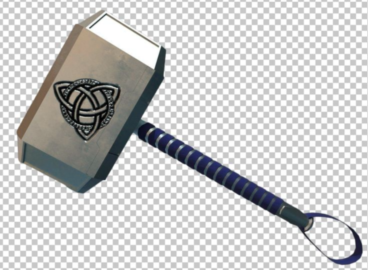

In [ ]:
img

In [ ]:
contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
for c in contours:
  # Find the bounding box coordinates
  x, y, w, h = cv2.boundingRect(c)
  cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

  # Find minimum area
  rect = cv2.minAreaRect(c)

  # Calculate coordinates of the minimum area rectangle
  box = cv2.boxPoints(rect)

  # Normalize coordinates to integers
  box = np.int0(box)

  # Draw contours
  cv2.drawContours(img, [box], 0, (0, 0, 255), 3)

  # Calculate center and radius of minimu enclosing circle
  (x, y), radius = cv2.minEnclosingCircle(c)

  # Cast to integers
  center = (int(x), int(y))
  radius = int(radius)

  # Draw the circle
  img = cv2.circle(img, center, radius, (0, 255, 0), 2)

<ipython-input-48-935b8ec75673>:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


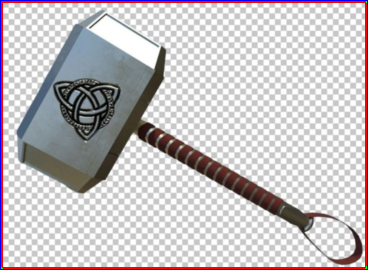

In [ ]:
cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
cv2_imshow(img)

**Explain what has happened so far.**

In [ ]:
x, y, w, h = cv2.boundingRect(c)

This is a pretty straightforward conversion of contour information to the (x, y) coordinates, plus the height and width of the rectangle. Drawing this rectangle is an easy task and can be done using this code:

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]], dtype=uint8)
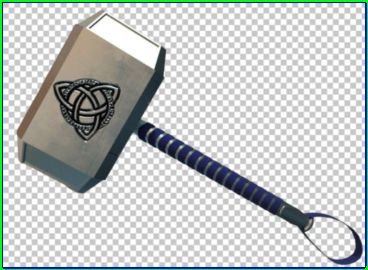

In [ ]:
cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

Secondly, let's calculate the minimum area enclosing the subject:

In [ ]:
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)

<ipython-input-52-ceb1eab3a452>:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


The mechanism used here is particularly interesting: OpenCV does not have a function to calculate the coordinates of the minimum rectangle vertexes directly from the contour information. Instead, we calculate the minimum rectangle area, and then
calculate the vertexes of this rectangle.

Note that the calculated vertexes are floats, but pixels are accessed with integers (you can't access a "portion" of a pixel), so we need to operate this conversion. Next, we draw the box, which gives us the perfect opportunity to introduce the cv2.drawContours function:

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
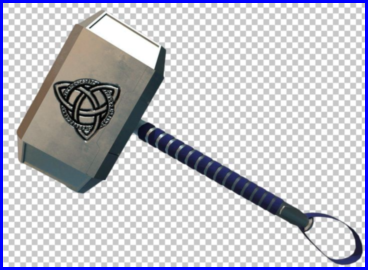

In [ ]:
cv2.drawContours(img, [box], 0, (0, 0, 255), 3)

Firstly, this function—like all drawing  functions—modifies the original image. Secondly, it takes an array of contours in its second parameter, so you can draw a number of contours in a single operation. Therefore, if you have a single set of points representing a contour polygon, you need to wrap these points into an array, exactly like we did with our box in the preceding example. The third parameter of this function specifies the index of the contours array that we want to draw: a value of -1 will draw all contours; otherwise, a contour at the specified index in the contours array (the second parameter) will be drawn.

Most drawing functions take the color of the drawing and its thickness as the last two parameters.

The last bounding contour we're going to examine is the minimum enclosing circle:

In [ ]:
(x, y), radius = cv2.minEnclosingCircle(c)
center = (int(x), int(y))
radius = int(radius)
img = cv2.circle(img, center, radius, (0, 255, 0), 2)

The only peculiarity of the cv2.minEnclosingCircle function is that it returns a two-element tuple, of which the first element is a tuple itself, representing the coordinates of the circle's center, and the second element is the radius of this circle. After converting all these values to integers, drawing the circle is quite a trivial operation.

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0,   0, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]], dtype=uint8)
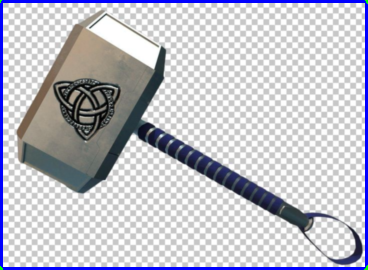

In [ ]:
img

**Show the final image output and provide an analysis. Does it look similar to the image shown below?**

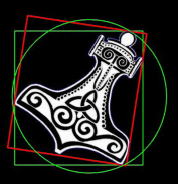

## 4. Supplementary Activity

For this section of the activity, you must have your favorite fictional character's picture ready.

Perform/Answer the following:
* Run all classes above meant to filter an image to your favorite character.
* Use edge detection and contour detection on your fave character. Do they indicate the same?
* Modify your character's picture such that bounding boxes similar to what happens in the last procedure will be written on the image.
* Research on the benefits of using canny and contour detection. What happens to the image after edge detection? What happens when you apply contour straight after?

## 5. Summary, Conclusions and Lessons Learned

<hr/>

***Proprietary Clause***

*Property of the Technological Institute of the Philippines (T.I.P.). No part of the materials made and uploaded in this learning management system by T.I.P. may be copied, photographed, printed, reproduced, shared, transmitted, translated, or reduced to any electronic medium or machine-readable form, in whole or in part, without the prior consent of T.I.P.*